# Visibility Calculations

Based on code by Rachel Street and Markus Hundertmark.

The visibility of any point in the sky on a given night from the Rubin Observatory is a fixed function of it's annual visibility.  While this can be calculated on the fly, it is quite computationally intensive, so to speed up software that uses this information we precalculate a matrix of the number of hours per day that each HEALpixel on the sky is visible from the Rubin site in Chile. 

The resulting dataset can be stored in an HD5 data structure, which can be quickly read and interpolated over as required.  

In [1]:
import astropy
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time, TimeDelta
from astropy.coordinates import get_sun
from astropy.table import Table, Column
#from astropy.coordinates import get_moon
import numpy as np
import healpy as hp
import copy
import healpixel_functions
import matplotlib.pyplot as plt
from scipy import interpolate

Firstly we declare the locations of the Rubin Observatory telescope sites at Cerro Pachon, Chile

In [2]:
def rubin_site():
    """Function returns the locations of Rubin Observatory at Cerro Pachon, Chile as an Astropy EarthLocation"""
   
    return EarthLocation(lat=-30.244633*u.deg, lon=-70.749416667*u.deg, height=2647*u.m)
    

Pre-cursor code by Markus, providing a True/False flag on whether a target is visible or not, given a location and date.

In [3]:
def check_observability(observatory_site, jd_obs, ra_target, dec_target, 
                        alt_limit = 60., bad_weather_fraction = 0.7):

    
    target = SkyCoord(ra=ra_target*u.degree, dec=dec_target*u.degree)
    time_stamp = Time(jd_obs,format='jd')

    if np.random.random() < bad_weather_fraction: 
        alt = target.transform_to(AltAz(obstime=time_stamp, 
                                        location=observatory_site)).alt
        if alt > alt_limit*u.deg:
            alt_sun = get_sun(time_stamp).transform_to(AltAz(obstime=time_stamp, 
                                                              location=observatory_site)).alt
            if alt_sun<-18.*u.deg:
                return True
            
    return False

The goal is to calculate the number of hours out of 24 for which a location in the sky is visible to the Rubin Observatory, as a function of dates throughout the year.  

The function below provides the core of a visibility calculator, given a specific target, observatory and date.

In [4]:
def calculate_visibility(target, observatory, obs_date, min_alt=30.0, verbose=False):
    """Method to calculate the visibility of a given RA and Dec from an Earth-based 
    observatory for a specific date.  

    Adapted from an example in the Astropy docs.

    Inputs:
        :param SkyCoord target: RA, Dec coordinate of a target, ICRS
        :param EarthLocation observatory: Location of observer
        :param Time obs_date: Midnight on the date of observations, assumed to be UTC 
    """

    jd = obs_date.jd
    cadence = 0.04 # days i.e. 1 hr time resolution

    # Store the date formating for logging:
    t  = copy.copy(obs_date)
    t.out_subfmt = 'date'
    tstr = t.value
    
    # Calculate visibility information for hourly intervals throughout the night
    intervals = np.arange(0.0,1.0,cadence)
    dt = TimeDelta(intervals, format='jd', scale=None)
    ts = obs_date + dt

    # Establish the Earth-based observatory as a frame of reference
    frame = AltAz(obstime=ts, location=observatory)
    
    # Calculate the target altitude above the local horizon at each timestamp, and
    # identify those times when the target is above the minimum observable altitude
    altaz = target.transform_to(frame)
    alts = np.array((altaz.alt*u.deg).value)
    idx = np.where(alts > min_alt)[0]

    # Calculate the altitude of the Sun from the observatory at each timestamp, 
    # and identify when it is below 12.0deg, i.e. the timestamps of local night
    sun_altaz = get_sun(ts).transform_to(frame)
    sun_alts = np.array((sun_altaz.alt*u.deg).value)
    jdx = np.where(sun_alts < 12.0)[0]

    # Store the number of hours of darkness available for this site on this date
    dark_hrs = cadence*len(sun_alts[jdx])*24.0

    # Calculate the intersection of the hours of darkness with target visibility, and 
    # the number of hours that the target is visible
    idx = list(set(idx).intersection(set(jdx)))
    #target_alts = alts[jdx].max()

    if len(idx) > 0:

        ts_vis = ts[idx]
        tvis = cadence * len(ts_vis)
        hrs_visible = tvis*24.0

        if verbose:
            print('Target visible for '+str(round(tvis*24.0,2))+\
                'hrs on '+tstr)

    else:

        hrs_visible = 0.0

        if verbose:
            print('Target not visible on '+tstr)

    return hrs_visible


The next cell demonstrates the use of the function above. 

In [6]:
# Get the location of the observatory
obs_site = rubin_site()

# Pick on-sky target coordinates.  Here we use the Galactic Bulge as an example
target = SkyCoord('18:02:48.75', '-35:41:07.20', frame='icrs', unit=(u.hourangle, u.deg))

# Define the date of observation
obs_date = Time('2023-08-15'+'T00:00:00', format='isot')

# Use the function above to calculate the number of hours that Rubin could observe this point in the sky on 
# the date given
hrs_visible = calculate_visibility(target, obs_site, obs_date, min_alt=30.0)
print('Hours of visibility = '+str(hrs_visible))

Hours of visibility = 8.64


## Calculating Visibility Sky Maps

Here we calculate the visibility of each HEALpixel in the sky from the Rubin Sbservatory, for a representative set of dates throughout the year.  This creates a 2D array (Date, HEALpixel) of the number of observable hours per night.  

This information can then be used to estimate the visibility of a target by identifying the HEALpixel it is located in, and interpolating as necessary to extract the hours of visibility per night for the range of observing nights.  

We need to calculate the visibility of the target for a fairly dense grid of dates throughout each year, but not so dense that the compute time is massively increased.  Here we use intervals of 1-week.  While a specific year is given here, this is the same for all years. 

In [13]:
start_date = Time('2023-01-01'+'T00:00:00', format='isot')
end_date = Time('2023-12-31'+'T00:00:00', format='isot')

dates = np.array([start_date + \
                TimeDelta(i,format='jd',scale=None) for i in range(0,364,7)])

Similarly, we will calculate for a fairly dense grid of HEALpixels across the sky

In [14]:
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
pix_res = hp.nside2resol(NSIDE, arcmin = True)/60.0
print('NSIDE = '+str(NSIDE)+' returns a map with '+str(NPIX)+' HEALpixels, resolution '+str(pix_res)+'deg')
t = 10.0 # ms
tcompute = (NPIX * t * 52)/1000.0/3600.0
print('Estimated compute time = '+str(tcompute)+'hrs')

NSIDE = 32 returns a map with 12288 HEALpixels, resolution 1.8322594196359498deg
Estimated compute time = 1.7749333333333335hrs


From this we can size the storage array for the resulting visibility data

In [15]:
visibility_table = np.zeros((NPIX, len(dates)))

Now we calculate Rubin's visibility for each HEALpixel and each date

In [16]:
obs_site = rubin_site()

# Time the calculation for reference
tstart = Time.now()
    
# Calculate for each HEALpixel in the sky
for ipix in range(0,NPIX,1):

    # Get a SkyCoord at the centre of this HEALpixel
    target = healpixel_functions.HPindex_to_skycoord(ipix, NSIDE)
    if (float(ipix)%100) == 0: print('-> Calculating for HEALpixel '+str(ipix))

    # Calculate that HEALpixel's visibility for all dates
    for t, obs_date in enumerate(dates):
        hrs_visible = calculate_visibility(target, obs_site, obs_date, min_alt=30.0)

        visibility_table[ipix,t] = hrs_visible
        
tend = Time.now()
tcompute = tend - tstart
print('Compute time = '+repr(tcompute))

print(visibility_table)

-> Calculating for HEALpixel 0
-> Calculating for HEALpixel 100
-> Calculating for HEALpixel 200
-> Calculating for HEALpixel 300
-> Calculating for HEALpixel 400
-> Calculating for HEALpixel 500
-> Calculating for HEALpixel 600
-> Calculating for HEALpixel 700
-> Calculating for HEALpixel 800
-> Calculating for HEALpixel 900
-> Calculating for HEALpixel 1000
-> Calculating for HEALpixel 1100
-> Calculating for HEALpixel 1200
-> Calculating for HEALpixel 1300
-> Calculating for HEALpixel 1400
-> Calculating for HEALpixel 1500
-> Calculating for HEALpixel 1600
-> Calculating for HEALpixel 1700
-> Calculating for HEALpixel 1800
-> Calculating for HEALpixel 1900
-> Calculating for HEALpixel 2000
-> Calculating for HEALpixel 2100
-> Calculating for HEALpixel 2200
-> Calculating for HEALpixel 2300
-> Calculating for HEALpixel 2400
-> Calculating for HEALpixel 2500
-> Calculating for HEALpixel 2600
-> Calculating for HEALpixel 2700
-> Calculating for HEALpixel 2800
-> Calculating for HEALpix

In [77]:
visibility_data = {'dates': np.array([ts.jd for ts in dates]),
                   'visibility_data': visibility_table}
visibility_data

{'observatories': array(['LSC', 'TFN', 'CPT', 'COJ', 'ELP'], dtype='<U3'),
 'dates': array([2459945.5, 2459952.5, 2459959.5, 2459966.5, 2459973.5, 2459980.5,
        2459987.5, 2459994.5, 2460001.5, 2460008.5, 2460015.5, 2460022.5,
        2460029.5, 2460036.5, 2460043.5, 2460050.5, 2460057.5, 2460064.5,
        2460071.5, 2460078.5, 2460085.5, 2460092.5, 2460099.5, 2460106.5,
        2460113.5, 2460120.5, 2460127.5, 2460134.5, 2460141.5, 2460148.5,
        2460155.5, 2460162.5, 2460169.5, 2460176.5, 2460183.5, 2460190.5,
        2460197.5, 2460204.5, 2460211.5, 2460218.5, 2460225.5, 2460232.5,
        2460239.5, 2460246.5, 2460253.5, 2460260.5, 2460267.5, 2460274.5,
        2460281.5, 2460288.5, 2460295.5, 2460302.5]),
 'visibility_data': array([[[ 0.  ,  0.  ,  0.  ,  0.  , 12.48],
         [ 0.  ,  0.  ,  0.  ,  0.  , 12.48],
         [ 0.  ,  0.  ,  0.  ,  0.  , 11.52],
         ...,
         [ 0.  ,  0.  ,  0.  ,  0.  , 14.4 ],
         [ 0.  ,  0.  ,  0.  ,  0.  , 13.44],
       

We can also now calculate the total number of hours that a given HEALpixel may be observed on a given date, combining all sites in the LCO 1m network. 

The total number of hours is calculated separately for telescopes in the northern and southern hemispheres, since the sites can observe sequentially, then summed:

total_hrs_visible = t_north + t_south,

where t_north = t_TFN + t_ELP
      t_south = t_COJ + t_CPT + t_LSC

In [85]:
def calc_network_hrs_visible(visibility_data, ipix):
    """Function to calculate the total number of hours that a given HEALpixel
    can be observed for, combining data from different sites.

    This is calculated separately for telescopes in the northern and
    southern hemispheres, since the sites can observe sequentially.

    total_hrs_visible = t_north + t_south,

    where t_north = t_TFN + t_ELP
          t_south = t_COJ + t_CPT + t_LSC

    Note the input HEALpixel identifier should be the array index, NOT
    the HEALpixel number
    """

    # Set up storage array, and identify the array indices of the telescopes in
    # the northern and southern hemispheres.
    data = np.zeros((len(visibility_data['dates']),2))

    observatories = list(visibility_data['observatories'])
    southern_ring = [observatories.index('LSC'),
                     observatories.index('CPT'),
                     observatories.index('COJ')]
    northern_ring = [observatories.index('ELP'),
                     observatories.index('TFN')]

    # Extract the visibility data for the requested pixel for
    # all sites as a 2D array:
    hrs_visible = visibility_data['visibility_data'][ipix,:,:]

    for idate in range(0,len(visibility_data['dates']),1):
        t_north = hrs_visible[idate, northern_ring].sum()
        t_south = hrs_visible[idate, southern_ring].sum()

        data[idate,0] = visibility_data['dates'][idate]
        data[idate,1] = min((t_north + t_south),24.0)

    return data


In [86]:
total_hrs_visible = np.zeros((NPIX,len(dates)))
for ipix in range(0,NPIX,1):
    vis_data = calc_network_hrs_visible(visibility_data, ipix)
    total_hrs_visible[ipix,:] = vis_data[:,1]
total_hrs_visible

array([[12.48, 12.48, 11.52, ..., 14.4 , 13.44, 13.44],
       [13.44, 13.44, 14.4 , ..., 11.52, 12.48, 12.48],
       [ 7.68,  7.68,  8.64, ...,  7.68,  7.68,  7.68],
       ...,
       [24.  , 24.  , 24.  , ..., 24.  , 24.  , 24.  ],
       [24.  , 24.  , 24.  , ..., 23.04, 23.04, 24.  ],
       [21.12, 22.08, 22.08, ..., 24.  , 22.08, 22.08]])

Store the computed visibility tables as an HD5 table

In [135]:
import h5py

# Convert the data arrays to a suitable format for HD5 storage. 
# Note that HD5 really doesn't like storing strings, and the easiest way
# around this problem appears to be to convert the array of observatory codes into a numeric 
# array.  
jd = np.array([(ts.decimalyear-int(ts.decimalyear)) for ts in dates])
site_codes = {'LSC': 0, 'CPT': 1, 'COJ': 2, 'ELP': 3, 'TFN': 4, 'OGG': 5}
sites = np.array([site_codes[x] for x in observatories.keys()])

file_path = 'lco_1m_network_visibility.hdf5'

with h5py.File(file_path, "w") as f:
    
    dset1 = f.create_dataset('healpix',
                            (NPIX),
                            dtype='int',
                            data=np.arange(1,NPIX+1,1))
    
    dset2 = f.create_dataset('decimalyear',
                            (len(dates)),
                            dtype='float64',
                            data=jd)
    
    dset3 = f.create_dataset('observatories',
                            (len(sites)),
                            dtype='int',
                            data=sites)
    
    dset4 = f.create_dataset('visibility_data',
                            visibility_table.shape,
                            dtype='float64',
                            data=visibility_table)
    
    dset5 = f.create_dataset('total_hrs_visible',
                            total_hrs_visible.shape,
                            dtype='float64',
                            data=total_hrs_visible)
    f.close()

Plotting the visibility data for a single site to check it...

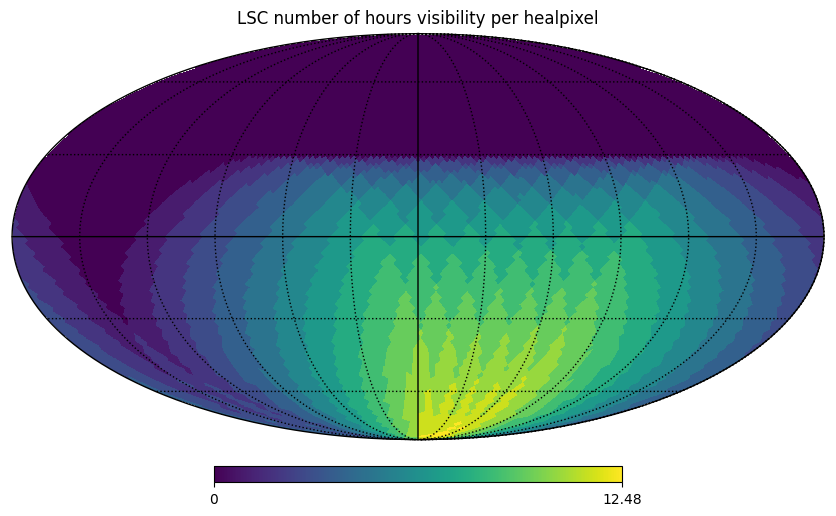

In [105]:
site = 'LSC'
site_index = list(observatories.keys()).index(site)
site_vis = visibility_table[:,:,site_index]

week = 31
hp.mollview(site_vis[:,week], title=site+' number of hours visibility per healpixel')
hp.graticule()

Plotting the total visibility data...

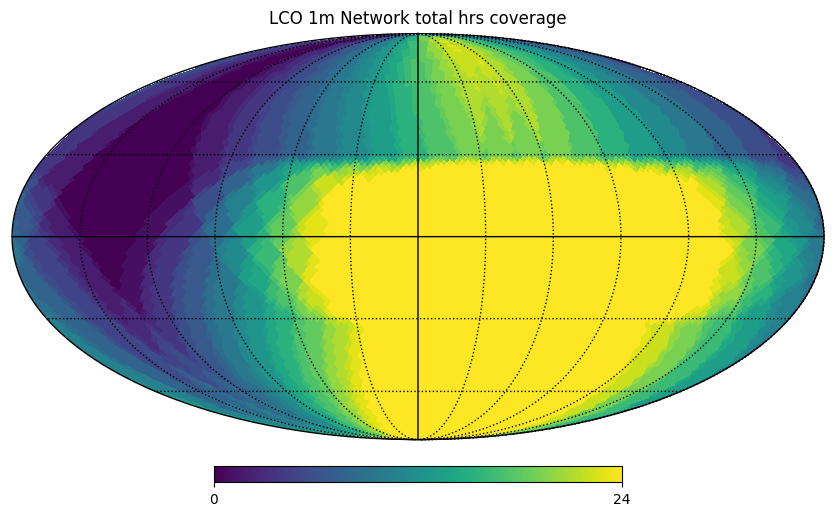

In [106]:
week = 31
hp.mollview(total_hrs_visible[:,week], title="LCO 1m Network total hrs coverage")
hp.graticule()

The intended usage of this map is that a given target event with an RA, Dec location can be located to a specitic healpixel.  The map above can then be used to extract the total number of hours out of 24 that the LCO 1m network can observe that HEALpixel, for weeks throughout the year.  

Target at 18:02:48.75, -35:41:07.20 is located on HEALpixel 9632


Text(0.5, 1.0, 'LCO 1m Network visibility of 18:02:48.75, -35:41:07.20')

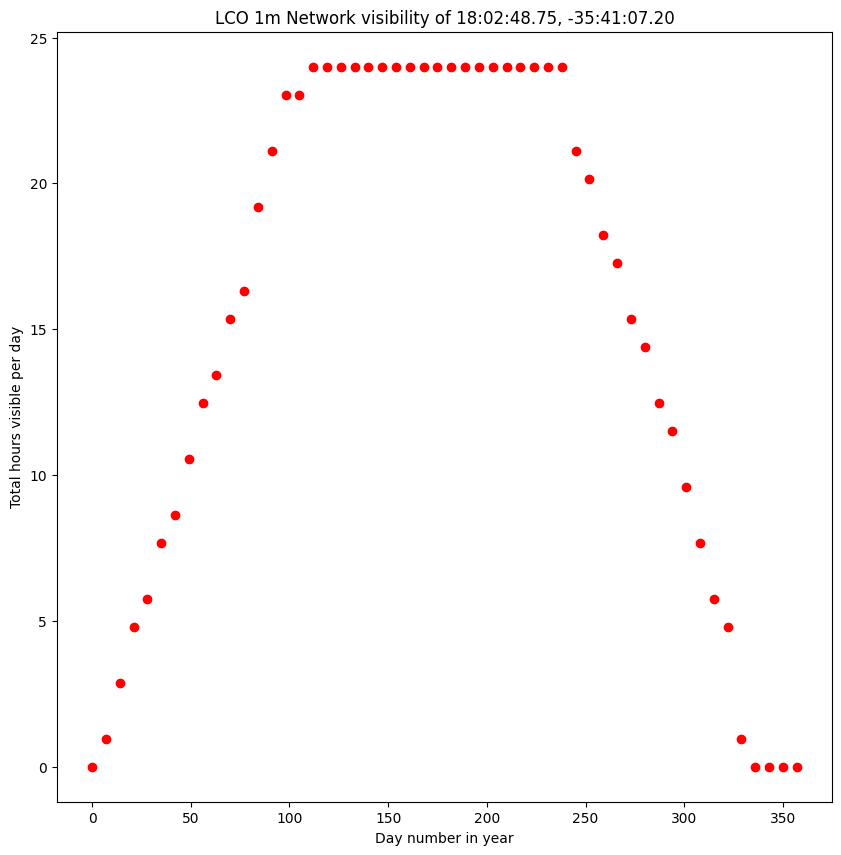

In [116]:
RA = '18:02:48.75'
Dec = '-35:41:07.20'
s = SkyCoord(RA, Dec, frame='icrs', unit=(u.hourangle, u.deg))
hpindex = healpixel_functions.skycoord_to_HPindex(s, 32, radius=2.0)
ipix = hpindex[0]
print('Target at '+RA+', '+Dec+' is located on HEALpixel '+str(ipix))

ts = np.array([x.jd for x in dates])
ts = ts - ts.min()
pixel_visibility = total_hrs_visible[ipix,:]

fig = plt.figure(1,(10,10))
plt.plot(ts, pixel_visibility, 'ro')
plt.xlabel('Day number in year')
plt.ylabel('Total hours visible per day')
plt.title('LCO 1m Network visibility of '+RA+', '+Dec)

Interpolating over these data then gives us a function which can be used to estimate the expected visibility of any target on any range of dates. 

Text(0.5, 1.0, 'LCO 1m Network visibility of 18:02:48.75, -35:41:07.20')

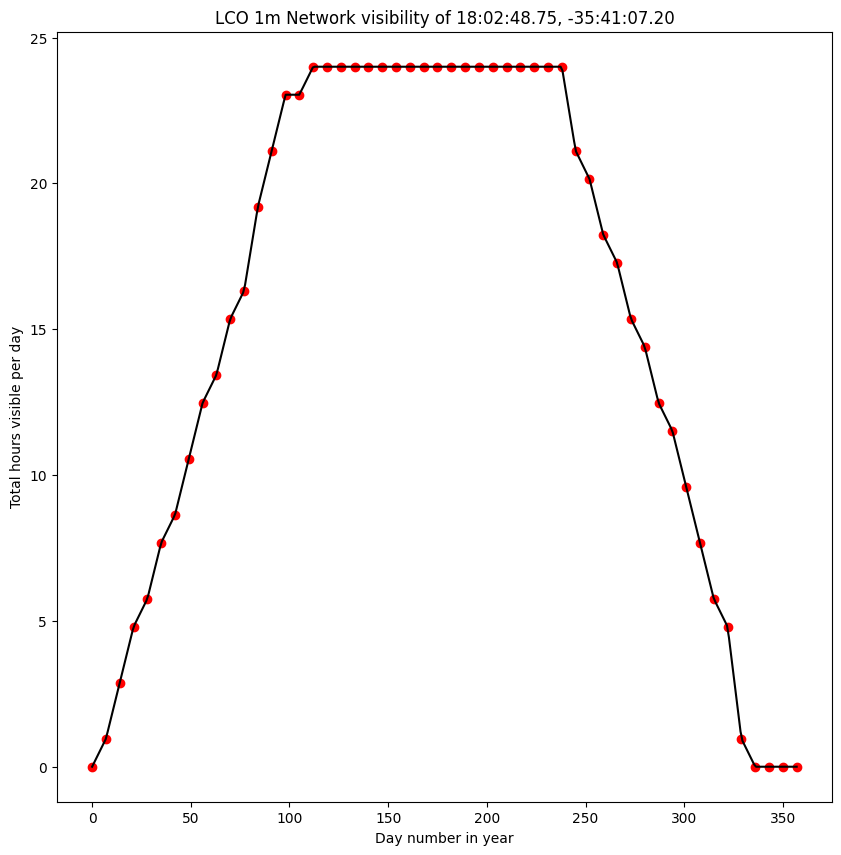

In [131]:
pixel_vis_func = interpolate.interp1d(visibility_data['dates'], pixel_visibility)

ts2 = np.linspace(visibility_data['dates'].min(), visibility_data['dates'].max(), 365)
y = pixel_vis_func(ts2)
ts2 = ts2 - ts2.min()

fig = plt.figure(2,(10,10))
plt.plot(ts, pixel_visibility, 'ro')
plt.plot(ts2, y, 'k-')
plt.xlabel('Day number in year')
plt.ylabel('Total hours visible per day')
plt.title('LCO 1m Network visibility of '+RA+', '+Dec)